In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [3]:
# read csv
test_df = pd.read_csv('test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales_train = pd.read_csv('sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [4]:
#merge sales_train & shops & item_categories and drop duplicate columns
train_df = sales_train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [5]:
#A glimpse of data
train_df.head().append(train_df.tail())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
2935844,2015-10-10,33,25,7409,299.000000,1,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935845,2015-09-10,33,25,7460,299.000000,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.000000,1,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.000000,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3
2935848,2015-03-10,33,25,7460,299.000000,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства


In [6]:
train_df.nunique()

date                   1034
date_block_num           34
shop_id                  60
item_id               21807
item_price            19992
item_cnt_day            198
item_name             21807
item_category_id         84
shop_name                60
item_category_name       84
dtype: int64

In [7]:
train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.906234e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.726440e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


## Pre-processing

In [8]:
#Data Leakage - Shop_id & item_id are the only two features when we predict test data. Thus, we could train our model on the train data with existing shop_id & item_id in test group
test_shop_ids = test_df['shop_id'].unique()
test_item_ids = test_df['item_id'].unique()
 
lk_train_df = train_df[train_df['shop_id'].isin(test_shop_ids)]

lk_train_df = lk_train_df[lk_train_df['item_id'].isin(test_item_ids)]

train_df_new = lk_train_df[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
train_df_new.head().append(train_df_new.tail())


,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,37,22154,999.0,1
10,2013-03-01,0,25,55,2574,399.0,2
11,2013-05-01,0,25,55,2574,399.0,1
12,2013-07-01,0,25,55,2574,399.0,1
13,2013-08-01,0,25,55,2574,399.0,2
2935844,2015-10-10,33,25,55,7409,299.0,1
2935845,2015-09-10,33,25,55,7460,299.0,1
2935846,2015-10-14,33,25,55,7459,349.0,1
2935847,2015-10-22,33,25,57,7440,299.0,1
2935848,2015-03-10,33,25,55,7460,299.0,1


In [9]:
#Duplication
print(train_df_new.duplicated().any())
print('**'*30)
##Null value
print(train_df_new.isnull().sum())

True
************************************************************
date                0
date_block_num      0
shop_id             0
item_category_id    0
item_id             0
item_price          0
item_cnt_day        0
dtype: int64


In [10]:
train_df_new = train_df_new.drop_duplicates()

In [11]:
#sum & average of item_price & item_cnt_day on a monthly basis
train_df_new = train_df_new.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_df_new = train_df_new.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})


In [12]:
print(train_df_new)

       date_block_num shop_id item_category_id item_id    item_price  \
                                                                 sum   
0                   0       2                2    5572  10730.000000   
1                   0       2                2    5643   4775.209961   
2                   0       2                5    5583   1188.300049   
3                   0       2                6    7893   5970.000000   
4                   0       2                6    7894   1490.000000   
...               ...     ...              ...     ...           ...   
600154             33      59               75    5383   4390.000000   
600155             33      59               79   17717   8025.500000   
600156             33      59               83   22087    357.000000   
600157             33      59               83   22088    238.000000   
600158             33      59               83   22091    179.000000   

                    item_cnt_day                  
            

In [13]:
# Rename features.
train_df_new.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
train_df_new.head().append(train_df_new.tail())

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.000000,1532.857178,9,1.285714,7
1,0,2,2,5643,4775.209961,2387.604980,0,0.000000,2
2,0,2,5,5583,1188.300049,594.150024,2,1.000000,2
3,0,2,6,7893,5970.000000,1990.000000,3,1.000000,3
4,0,2,6,7894,1490.000000,1490.000000,1,1.000000,1
600154,33,59,75,5383,4390.000000,4390.000000,1,1.000000,1
600155,33,59,79,17717,8025.500000,802.549988,13,1.300000,10
600156,33,59,83,22087,357.000000,119.000000,6,2.000000,3
600157,33,59,83,22088,238.000000,119.000000,2,1.000000,2
600158,33,59,83,22091,179.000000,179.000000,1,1.000000,1


In [14]:
# data cleaning based on shop_id and item_id
shop_ids = train_df_new['shop_id'].unique()
item_ids = train_df_new['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
 
train_df_new = pd.merge(empty_df, train_df_new, on=['date_block_num','shop_id','item_id'], how='left')
 
train_df_new.fillna(0, inplace=True)
 
train_df_new['year'] = train_df_new['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_df_new['month'] = train_df_new['date_block_num'].apply(lambda x: (x % 12))

In [15]:
train_df_new

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0
...,...,...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734444,33,36,9107,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734445,33,36,5704,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734446,33,36,12733,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9


In [16]:
monthly_mean = train_df_new.groupby(['month'], as_index=False)['item_cnt'].mean()
monthly_sum = train_df_new.groupby(['month'], as_index=False)['item_cnt'].sum()
category_mean = train_df_new.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
category_sum = train_df_new.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
shop_mean = train_df_new.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
shop_sum = train_df_new.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

## EDA

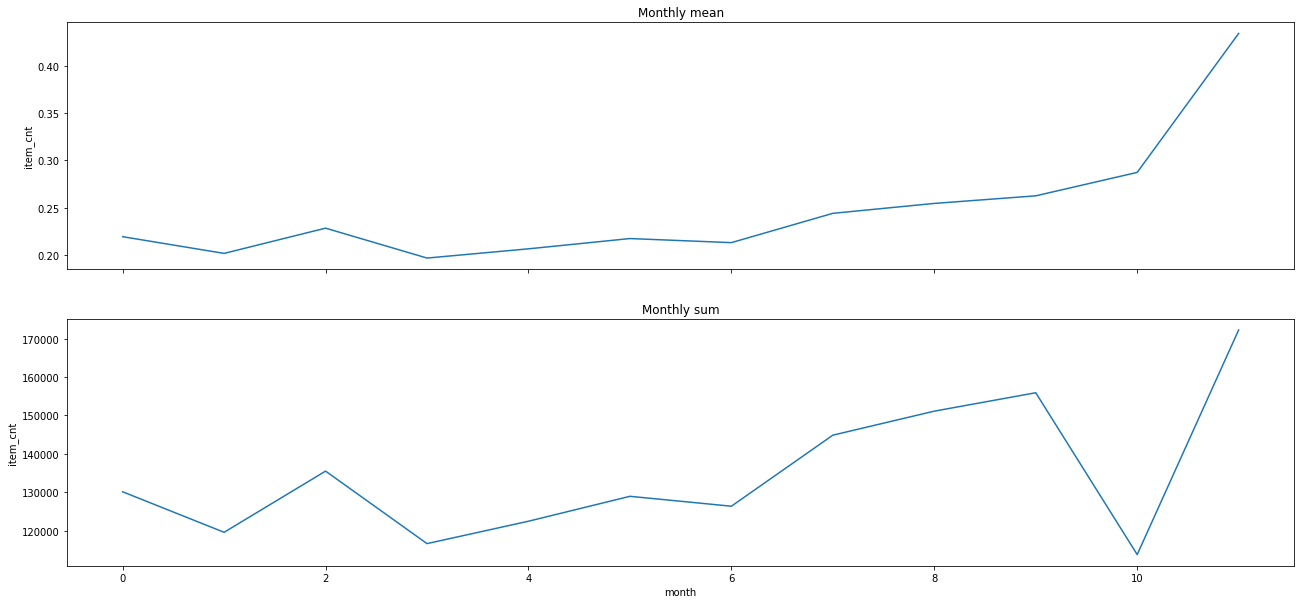

In [17]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=monthly_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=monthly_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

Sales increase towards the end of the year

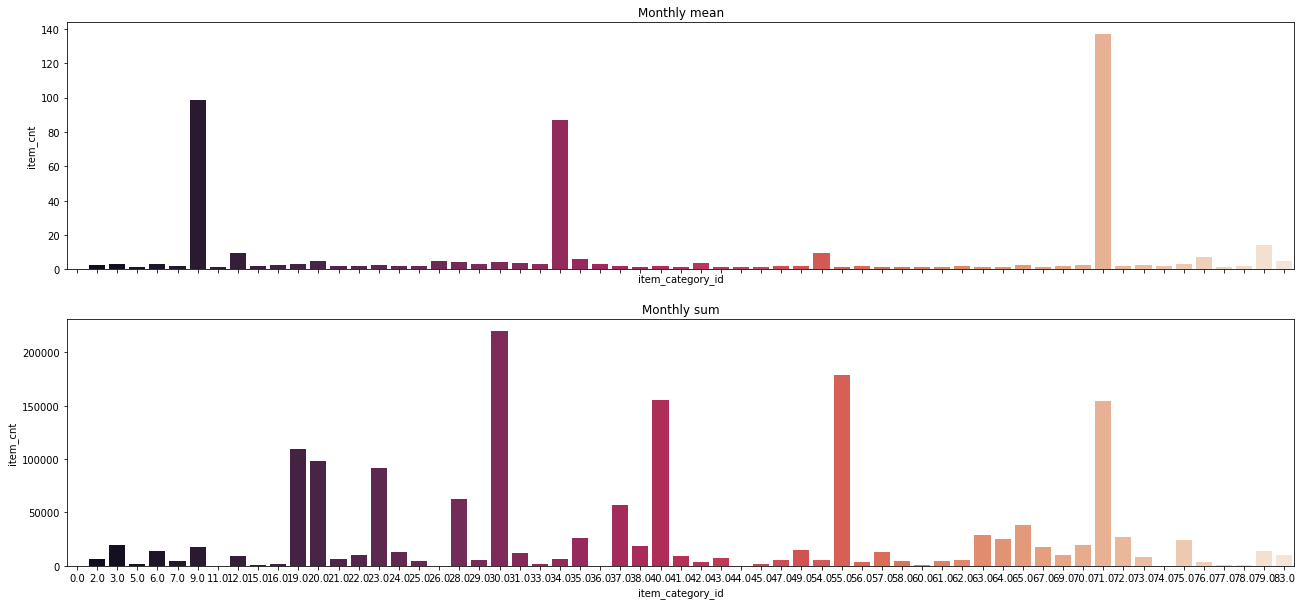

In [18]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

Only certain categories contribute more to the sales

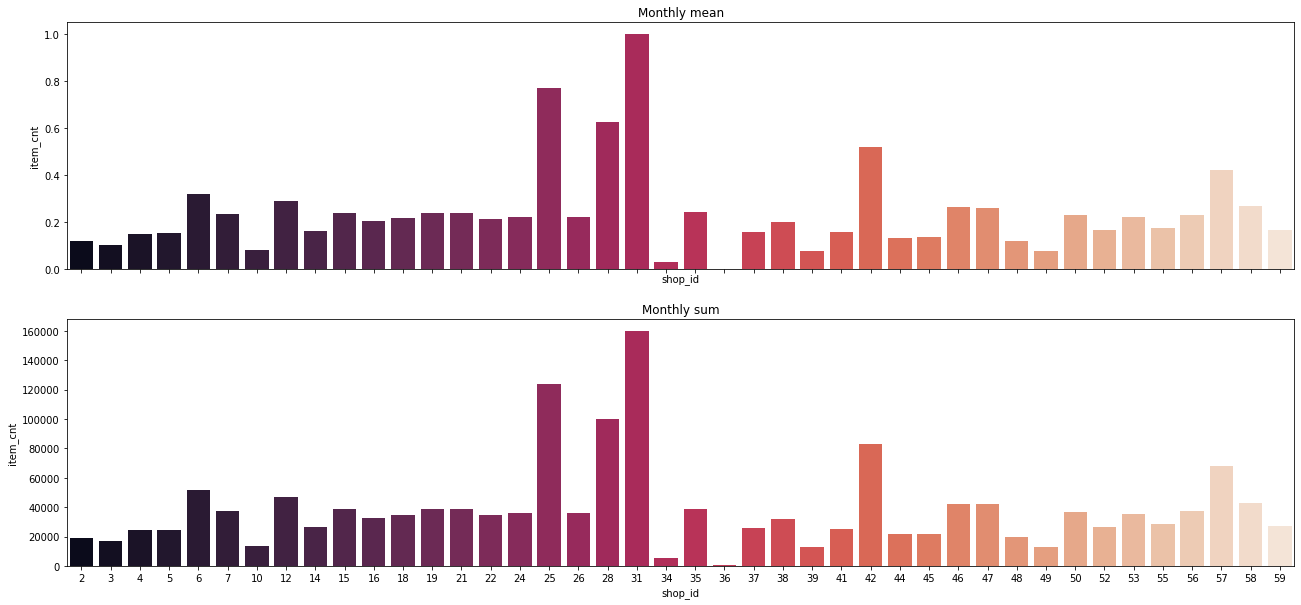

In [19]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

Shop_id: 25, 28, 31 contribute more to the sales, might be big markets, malls, etc.

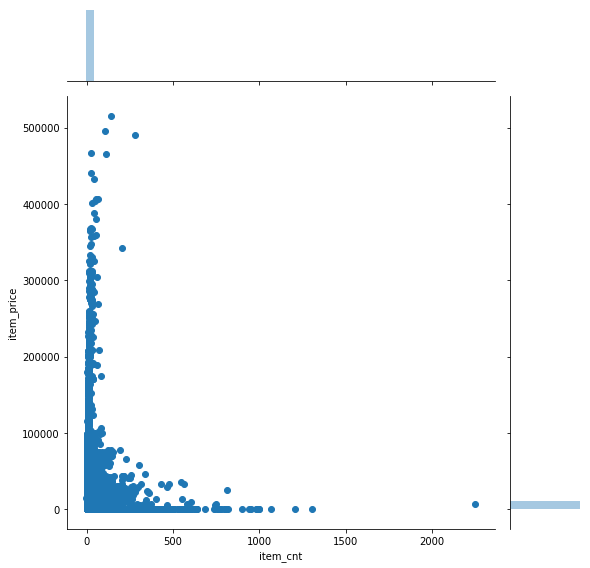

In [20]:
sns.jointplot(x='item_cnt', y='item_price', data = train_df_new, height =8)
plt.show()

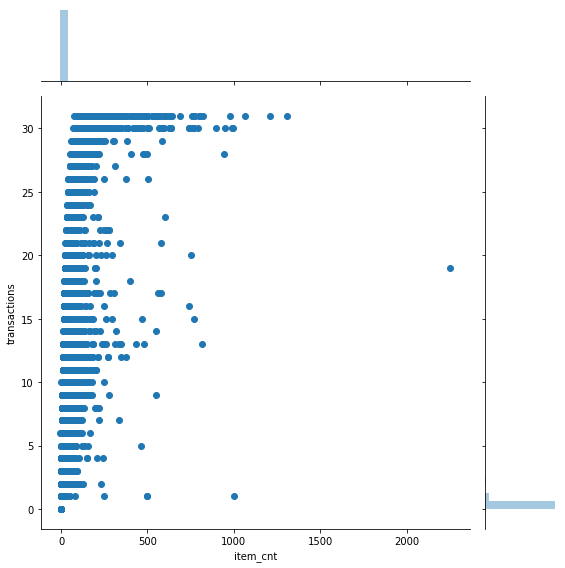

In [21]:
sns.jointplot(x='item_cnt', y='transactions', data = train_df_new, height =8)
plt.show()

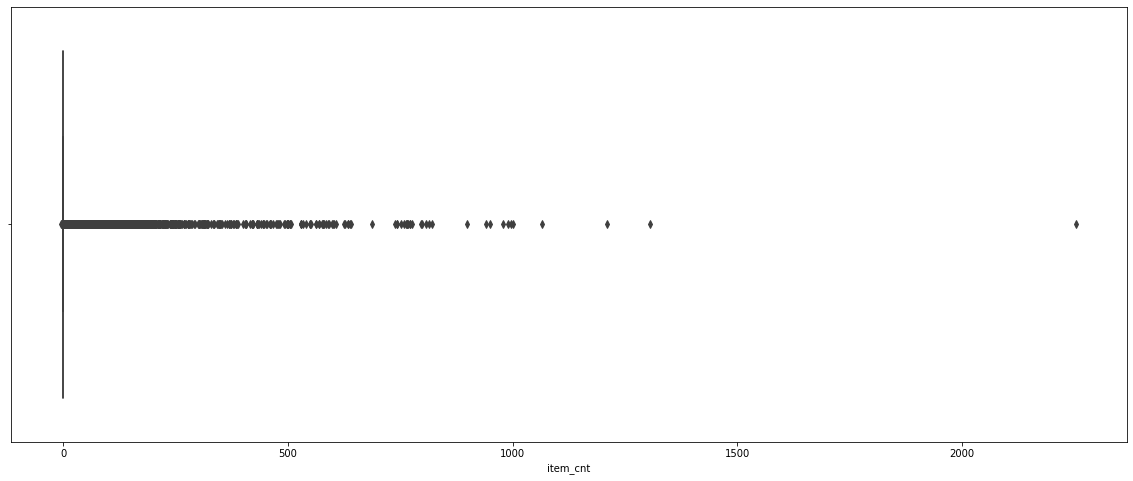

In [22]:
plt.subplots(figsize=(20,8))
sns.boxplot(train_df_new['item_cnt'])
plt.show()

We could come to a conclusion that any item_cnt value not in the range between 0 and 20, and item_price over 40000 should be considered as outliers and would be removed.

In [23]:
train_df_new = train_df_new.query('item_cnt >= 0 and item_cnt <=20 and item_price < 400000')
train_df_new.head().append(train_df_new.tail())

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0
6734443,33,36,9103,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734444,33,36,9107,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734445,33,36,5704,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734446,33,36,12733,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734447,33,36,15925,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9


## Feature Engineering

The task requires us to create columns of forecast observations for a time series dataset, so we create the new label by pull back the values

In [24]:
train_df_new['item_cnt_month'] = train_df_new.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)   #sales of the next month

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Create new column"item_price_unit" by divided total sales for one item by its count, and fill the null value with 0

In [25]:
train_df_new['item_price_unit'] = train_df_new['item_price'] // train_df_new['item_cnt']
train_df_new['item_price_unit'].fillna(0, inplace=True)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
E:\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


For each product, calculate its price characteristics, including minimun price, maximum price, and difference between the item price and min/max price.

In [26]:
item_price = train_df_new.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']
 
train_df_new = pd.merge(train_df_new, item_price, on='item_id', how='left')

#print(train_df_new)

train_df_new['price_increase'] = train_df_new['item_price'] - train_df_new['hist_min_item_price']
train_df_new['price_decrease'] = train_df_new['hist_max_item_price'] - train_df_new['item_price']

In [27]:
train_df_new.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0,1.0,1192.0,0.0,18979.5,10730.000000,8249.500000
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0,0.0,inf,0.0,35260.0,4775.209961,30484.789062
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0,1.0,594.0,0.0,5592.0,1188.300049,4403.700195
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0,2.0,1990.0,0.0,27950.0,5970.000000,21980.000000
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0,2.0,1490.0,0.0,25880.0,1490.000000,24390.000000


In [30]:
train_df_new.to_csv('train_df.csv')

In [ ]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [ ]:
print(X_train.head())

In [ ]:
print(X_validation.head())